# Challenge - Supervised learning: Regression problems


## The scenario
The housing market is one of the most crucial parts of the economy for every country. Purchasing a home is one of the primary ways to build wealth and savings for people. In this respect, predicting prices in the housing market is a very central topic in economic and financial circles.

The house price dataset from Kaggle includes several features of the houses along with their sale prices at the time they are sold. So far, in this module, you built and implemented some models using this dataset.

In this challenge, you are required to improve your model with respect to its prediction performance.

To complete this challenge, submit a Jupyter notebook containing your solutions to the following tasks.

## Steps
    * Load the houseprices data from Thinkful's database.
    * Do data cleaning, exploratory data analysis, and feature engineering. You can use your previous work in this module. But make sure that your work is satisfactory.
    * Now, split your data into train and test sets where 20% of the data resides in the test set.
    * Build several linear regression models including Lasso, Ridge, or ElasticNet and train them in the training set. Use k-fold cross-validation to select the best hyperparameters if your models include one!
    * Evaluate your best model on the test set.

### Notebook Flow

#### From previous notebooks
    * Importing libraries
    * Loading data
    * Brief EDA and preprocessing as done in earlier assignments within this module
    * Linear Regression Results From Previous Notebook

#### Attempting to optomize prediction performance
    * Feature Engineering - Adding Principle Components
    * Re-run Regression models w/ OLS, Lasso, Ridge, & ElasticNet
    * Compare Results
    * Create New linear models using only Principle Components w/ OLS, Lasso, Ridge, & ElasticNet

# Importing Libraries

In [1]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV, ElasticNetCV
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from scipy.stats.mstats import winsorize
from sklearn import preprocessing
from statsmodels.tools.eval_measures import mse, rmse
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from sqlalchemy import create_engine

import warnings
warnings.filterwarnings('ignore')

## Loading Data

In [2]:
postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'houseprices'

engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))
homes_df = pd.read_sql_query('select * from houseprices',con=engine)

# no need for an open connection, as we're only doing a single query
engine.dispose()


## Brief EDA and preprocessing as done in earlier assignments within this module

First, it should be noted that I am using the same data cleaning process I've used throughout this entire Thinkful Chapter, but I want to elaborate on what was done an why. 

We have a regression task at hand, but some of our features are numeric and some are categorical. To include those variables I will need to encode those features as numeric features. 

5 of the features are missing more than 45% of values for their cooresponding observations. I will drop those features. 

Next I will drop other missing values at the observation level. 

Most our outliers are skewing the distributions of their respective features to the right. In order to limit those outliers affects on my models, I will unevenly winsorize each feature.

Text(0.5, 1.0, 'Target: saleprice ')

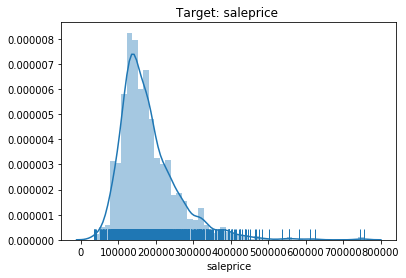

In [3]:
sns.distplot(homes_df.saleprice, rug=True)
plt.title("Target: saleprice ")

A lot of the distributions of our features look like the distribution of our target, depicted above. 

In [4]:
# Preparing data for modeling about house prices 

# ojects holding columns
non_numeric_columns = homes_df.select_dtypes(['object']).columns
numeric_columns = homes_df.select_dtypes(['int64', 'float64']).columns

# dropping columns Missing data
homes_df = homes_df.drop(['poolqc', 'miscfeature', 'alley', 
                          'fence', 'fireplacequ'], axis=1)

# Dropping missing observations
homes_df = homes_df.dropna(axis=0)

numeric_columns = numeric_columns.drop(['id'])

FILL_LIST = []
for cols in homes_df[:]:
    if cols in numeric_columns:
        FILL_LIST.append(cols)

In [5]:
# winsorizing numeric features
homes_win = homes_df.copy()
for col in FILL_LIST:
    homes_win[col] = winsorize(homes_win[col], (.05, .14))

In [6]:
# converting non-numeric features into numeric features
def cat_converter(df):
    for cols in df:
        if cols in non_numeric_columns:
            
            # Create a label (category) encoder object
            le = preprocessing.LabelEncoder()
            
            # Create a label (category) encoder object
            le.fit(df[cols])
            
            # Apply the fitted encoder to the pandas column
            df[cols] = le.transform(df[cols]) 
    return df

cat_converter(homes_win).head(1)

,id,mssubclass,mszoning,lotfrontage,lotarea,street,lotshape,landcontour,utilities,lotconfig,...,enclosedporch,threessnporch,screenporch,poolarea,miscval,mosold,yrsold,saletype,salecondition,saleprice
0,1,60,3,65.0,8450,1,3,3,0,4,...,0,0,0,0,0,2,2008,8,4,208500


In [7]:
# creating dataframe to hold everything needed for our model
homes_mod2 = homes_win[['neighborhood', 'bsmtfinsf1', 'heatingqc', 'grlivarea', 'saleprice']]

# selecting the "data" and "target"
X = homes_mod2.iloc[:, :-1]
y = homes_mod2['saleprice']

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=40)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(875, 4) (219, 4) (875,) (219,)


# Linear Regression Results From Previous Notebook

In [9]:
# create model instance
lrm = LinearRegression()

# Adding a constant Best Practice!
X_train = sm.add_constant(X_train)

# fit the model to the training data (learning coefficients)
lrm.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [10]:
# Adding a constant Best Practice!
X_test = sm.add_constant(X_test)

# Making predictions here
y_preds_train = lrm.predict(X_train)
y_preds_test = lrm.predict(X_test)

In [11]:
err_chart = pd.DataFrame(index=['Best alpha value', 'R-squared of training', 'R-squared of test',
                                'Mean absolute error', 'Mean squared error', 'Root mean squared error',
                                'Mean absolute percentage error'])

In [12]:
err_chart['OLS-orginal'] = list(['N/A', lrm.score(X_train, y_train), lrm.score(X_test, y_test),
                          mean_absolute_error(y_test, y_preds_test),
                          mse(y_test, y_preds_test), rmse(y_test, y_preds_test),
                          np.mean(np.abs((y_test - y_preds_test) / y_test) * 100)])

In [13]:
err_chart

,OLS-orginal
Best alpha value,N/A
R-squared of training,0.668801
R-squared of test,0.6633
Mean absolute error,26251.8
Mean squared error,1.05119e+09
Root mean squared error,32422.1
Mean absolute percentage error,16.3969


### The above model is based on the best feature combination I found up to this point working with this dataset via previous assignments. 

#### Back to EDA

##### Feature Engineering 
Previously I used Chi-Squared tests to find the features that our y variable may be dependant upon and use those features to fit our linear regression model and make predictions

What if I used PCA to create new vectors on the features not previously included in the best linear model so far and then ran OLS, Ridge, Lasso, and ElasticNet regression models? Would that produce a better result?

In [14]:
data_pca = homes_win.copy()
data_pca = data_pca.drop(['neighborhood', 'bsmtfinsf1', 'heatingqc', 'grlivarea'], axis=1)

In [15]:
data = data_pca.iloc[:, 1:-1]
target = data_pca['saleprice']

# Select 20 features with highest chi-squared scores
chi2_selector = SelectKBest(chi2, k=20)
chi2_selector.fit_transform(data, target)

# Get columns to keep
cols = chi2_selector.get_support(indices=True)

X_kbest = pd.DataFrame(chi2_selector.fit_transform(data, target))

# Create new dataframe with only desired columns, or overwrite existing
X_kbest_feat = data.iloc[:,cols]

In [16]:
X_kbest_feat.head()

,mssubclass,lotfrontage,lotarea,lotshape,landslope,bldgtype,housestyle,exterior1st,exterior2nd,masvnrarea,bsmtfintype1,bsmtunfsf,totalbsmtsf,firstflrsf,secondflrsf,garagetype,garagearea,wooddecksf,openporchsf,enclosedporch
0,60,65.0,8450,3,0,0,5,11,13,196.0,2,150,856,856,854,1,548,0,61,0
1,20,80.0,9600,3,0,0,2,7,8,0.0,0,284,1262,1262,0,1,460,222,0,0
2,60,68.0,11250,0,0,0,5,11,13,162.0,2,434,920,920,866,1,608,0,42,0
3,70,60.0,9550,0,0,0,5,12,15,0.0,0,540,756,961,756,5,642,0,35,32
4,60,84.0,13125,0,0,0,5,11,13,285.0,2,490,1145,1145,878,1,716,192,84,0


### Now that we have 20 variables that explain some of the varience in our target lets make sure this set of features is "eligible" for PCA

Correlations of 0, or correlations greater than .7 or .8, create problems for PCA. A few high or close zero correlations is fine. It is when we have a variable with mostly very high or very low correlations with other variables that problems can occur. 

Let's take a look to confirm.

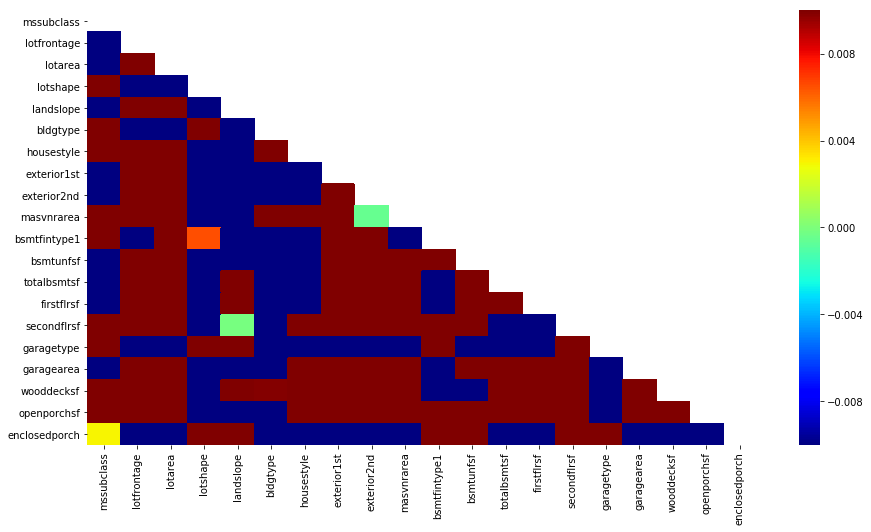

In [17]:
mask = np.zeros_like(X_kbest_feat.corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

plt.figure(figsize=(15, 8))
sns.heatmap(X_kbest_feat.corr(), cmap='jet', vmin=-0.01, vmax=0.01, mask=mask)

### There are a couple close to zero correlations, but not enough to consider removing variables. 

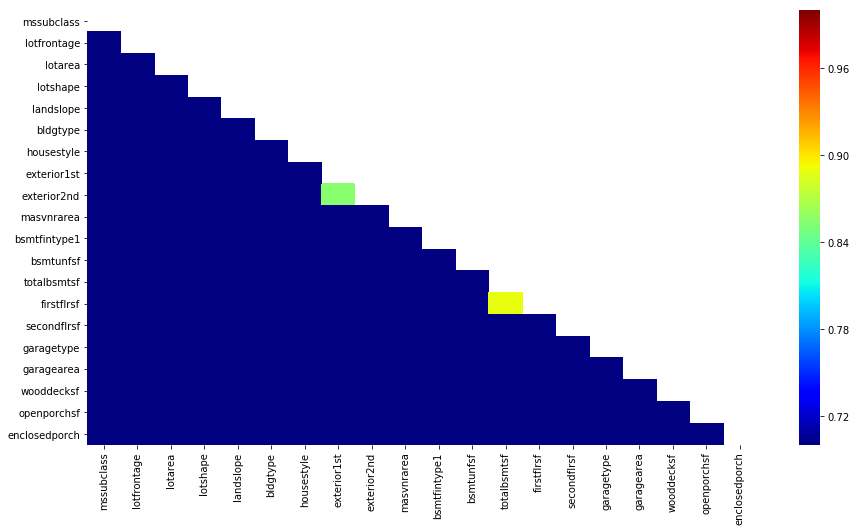

In [18]:
mask = np.zeros_like(X_kbest_feat.corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

plt.figure(figsize=(15, 8))
sns.heatmap(X_kbest_feat.corr(), cmap='jet', vmin=0.7, mask=mask)

We have a couple highly correlated features, but not enough to consider dropping one or the other. 

## PCA

In [19]:
# Normalize the data so that all variables have a mean of 0 and standard deviation
# of 1.
X = StandardScaler().fit_transform(X_kbest_feat)

sklearn_pca = PCA(n_components=20)

pca = sklearn_pca.fit_transform(X)

print('The percentage of total variance in the dataset explained by each',
      'component from Sklearn PCA.\n',
      sklearn_pca.explained_variance_ratio_)

The percentage of total variance in the dataset explained by each component from Sklearn PCA.
 [0.21055989 0.12191142 0.11369032 0.08976326 0.07140055 0.05333723
 0.0446141  0.04361068 0.03966619 0.03813216 0.03486904 0.03129274
 0.02311424 0.02107795 0.01858807 0.01496059 0.01199836 0.00705638
 0.00563042 0.00472641]


In [20]:
# The NumPy covariance function assumes that variables are represented by rows,
# not columns, so we transpose X.
def show_eigen(X):
    Xt = X.transpose()
    Cx = np.cov(Xt)
    eig_val_cov, eig_vec_cov = np.linalg.eig(Cx)
# Inspecting the eigenvalues and eigenvectors.
    cumulative = np.cumsum(eig_val_cov)
    plt.plot(eig_val_cov)
    return print(eig_val_cov)

[4.2150507  2.44045926 2.27588675 1.79690768 1.42931748 1.06772056
 0.09461463 0.11271142 0.14125676 0.89309838 0.87301156 0.79404962
 0.76334095 0.69801876 0.62642735 0.24018678 0.29948562 0.46270774
 0.37210161 0.42194466]


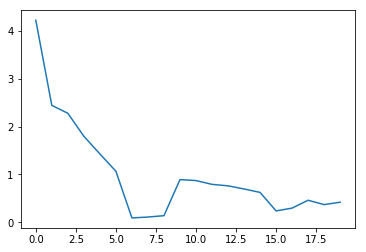

In [21]:
show_eigen(X)

The rule of thumb is to keep components with eigenvalues larger than 1.

In [22]:
principalDf = pd.DataFrame(data = pca[:, :6],
                           columns = ['principal component 1', 'principal component 2', 'principal component 3',
                                     'principal component 4', 'principal component 5', 'principal component 6'])

In [23]:
# Creating Data for modeling
homes_mod2.reset_index(drop=True, inplace=True)
principalDf.reset_index(drop=True, inplace=True)

homes_mod_p = pd.concat([homes_mod2, principalDf], axis=1)
homes_mod_p.head()

,neighborhood,bsmtfinsf1,heatingqc,grlivarea,saleprice,principal component 1,principal component 2,principal component 3,principal component 4,principal component 5,principal component 6
0,5,706,0,1710,208500,0.556071,1.553634,-1.178512,-0.829912,-1.130424,-1.330262
1,24,956,0,1262,181500,-0.914115,-0.997385,2.098590,-0.917475,-1.129814,-0.351439
2,5,486,0,1786,223500,-0.473764,1.519196,-1.575351,-1.061391,-0.753715,-0.097835
3,6,216,2,1717,140000,1.214743,0.431968,-2.149210,-0.871624,-0.899242,0.782132
4,15,655,0,2018,250000,-2.659125,2.498871,-1.550409,-1.194567,-0.590860,0.072243


# Linear Regression OLS + 6 Principle Components

In [24]:
# choosing data and target
X = homes_mod_p[['neighborhood', 'bsmtfinsf1', 'heatingqc', 'grlivarea',
                 'principal component 1', 'principal component 2', 'principal component 3',
                 'principal component 4', 'principal component 5', 'principal component 6']]
y = homes_mod_p[['saleprice']]

# train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=40)

# create model instance
lrm = LinearRegression()

# Adding a constant Best Practice!
X_train = sm.add_constant(X_train)

# fit the model to the training data (learning coefficients)
lrm.fit(X_train, y_train)

# Adding a constant Best Practice!
X_test = sm.add_constant(X_test)

# Making predictions here
y_preds_train = lrm.predict(X_train)
y_preds_test = lrm.predict(X_test)

err_chart['OLS_PCA'] = list(['N/A', lrm.score(X_train, y_train), lrm.score(X_test, y_test),
                          mean_absolute_error(y_test, y_preds_test),
                          mse(y_test, y_preds_test), rmse(y_test, y_preds_test),
                          np.mean(np.abs((y_test - y_preds_test) / y_test) * 100)])

In [25]:
err_chart

,OLS-orginal,OLS_PCA
Best alpha value,N/A,N/A
R-squared of training,0.668801,0.795209
R-squared of test,0.6633,0.78376
Mean absolute error,26251.8,19451.7
Mean squared error,1.05119e+09,[675108926.0118408]
Root mean squared error,32422.1,[25982.858311045013]
Mean absolute percentage error,16.3969,saleprice 12.218339 dtype: float64


Prediction performance improved quite a bit here. Lets check our reseults with regularization. 

# Regularization Lasso

In [26]:
# setting up a "alpha" obj
alphas = [np.power(10.0,p) for p in np.arange(-10,40,1)]

# choosing data and target
X = homes_mod_p[['neighborhood', 'bsmtfinsf1', 'heatingqc', 'grlivarea',
                 'principal component 1', 'principal component 2', 'principal component 3',
                 'principal component 4', 'principal component 5', 'principal component 6']]
y = homes_mod_p[['saleprice']]


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=40)

# creating lasso obj specifying "alpha" (lambda) and folds
lasso_cv = LassoCV(alphas=alphas, cv=5)

# adding constant
X_train = sm.add_constant(X_train)

# fitting data to target using lasso
lasso_cv.fit(X_train, y_train)

# Adding a constant Best Practice!
X_test = sm.add_constant(X_test)

# We are making predictions here
y_preds_train = lasso_cv.predict(X_train)
y_preds_test = lasso_cv.predict(X_test).reshape(-1,1)

err_chart['Reg_Lasso'] = list([lasso_cv.alpha_, lasso_cv.score(X_train, y_train), lasso_cv.score(X_test, y_test),
                          mean_absolute_error(y_test, y_preds_test),
                          mse(y_test, y_preds_test), rmse(y_test, y_preds_test),
                          np.mean(np.abs((y_test - y_preds_test) / y_test) * 100)])

In [27]:
err_chart

,OLS-orginal,OLS_PCA,Reg_Lasso
Best alpha value,N/A,N/A,1e-10
R-squared of training,0.668801,0.795209,0.795209
R-squared of test,0.6633,0.78376,0.78376
Mean absolute error,26251.8,19451.7,19451.7
Mean squared error,1.05119e+09,[675108926.0118408],[675108926.01184]
Root mean squared error,32422.1,[25982.858311045013],[25982.858311044994]
Mean absolute percentage error,16.3969,saleprice 12.218339 dtype: float64,saleprice 12.218339 dtype: float64


# Regularization Ridge

In [28]:
# train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=40)

# creating lasso obj specifying "alpha" (lambda) and folds
ridge_cv = RidgeCV(alphas=alphas, cv=5)

# adding constant
X_train = sm.add_constant(X_train)

# fitting data to target using lasso
ridge_cv.fit(X_train, y_train)

# Adding a constant Best Practice!
X_test = sm.add_constant(X_test)

# We are making predictions here
y_preds_train = ridge_cv.predict(X_train)
y_preds_test = ridge_cv.predict(X_test).reshape(-1,1)

err_chart['Reg_Ridge'] = list([ridge_cv.alpha_, ridge_cv.score(X_train, y_train), ridge_cv.score(X_test, y_test),
                          mean_absolute_error(y_test, y_preds_test),
                          mse(y_test, y_preds_test), rmse(y_test, y_preds_test),
                          np.mean(np.abs((y_test - y_preds_test) / y_test) * 100)])

In [29]:
err_chart

,OLS-orginal,OLS_PCA,Reg_Lasso,Reg_Ridge
Best alpha value,N/A,N/A,1e-10,10
R-squared of training,0.668801,0.795209,0.795209,0.795204
R-squared of test,0.6633,0.78376,0.78376,0.783637
Mean absolute error,26251.8,19451.7,19451.7,19450.1
Mean squared error,1.05119e+09,[675108926.0118408],[675108926.01184],[675493038.0347925]
Root mean squared error,32422.1,[25982.858311045013],[25982.858311044994],[25990.248902901883]
Mean absolute percentage error,16.3969,saleprice 12.218339 dtype: float64,saleprice 12.218339 dtype: float64,saleprice 12.215309 dtype: float64


# ElasticNet

In [30]:
# train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=40)

# creating lasso obj specifying "alpha" (lambda) and folds
elasticnet_cv = ElasticNetCV(alphas=alphas, cv=5)

# adding constant
X_train = sm.add_constant(X_train)

# fitting data to target using lasso
elasticnet_cv.fit(X_train, y_train)

# Adding a constant Best Practice!
X_test = sm.add_constant(X_test)

# We are making predictions here
y_preds_train = elasticnet_cv.predict(X_train)
y_preds_test = elasticnet_cv.predict(X_test).reshape(-1,1)

err_chart['Reg_ElasticNet'] = list([elasticnet_cv.alpha_, elasticnet_cv.score(X_train, y_train), elasticnet_cv.score(X_test, y_test),
                          mean_absolute_error(y_test, y_preds_test),
                          mse(y_test, y_preds_test), rmse(y_test, y_preds_test),
                          np.mean(np.abs((y_test - y_preds_test) / y_test) * 100)])

In [31]:
err_chart

,OLS-orginal,OLS_PCA,Reg_Lasso,Reg_Ridge,Reg_ElasticNet
Best alpha value,N/A,N/A,1e-10,10,0.1
R-squared of training,0.668801,0.795209,0.795209,0.795204,0.795115
R-squared of test,0.6633,0.78376,0.78376,0.783637,0.783154
Mean absolute error,26251.8,19451.7,19451.7,19450.1,19447.2
Mean squared error,1.05119e+09,[675108926.0118408],[675108926.01184],[675493038.0347925],[676998876.4922154]
Root mean squared error,32422.1,[25982.858311045013],[25982.858311044994],[25990.248902901883],[26019.202072550484]
Mean absolute percentage error,16.3969,saleprice 12.218339 dtype: float64,saleprice 12.218339 dtype: float64,saleprice 12.215309 dtype: float64,saleprice 12.206746 dtype: float64


Okay so regularization had a marginal affect on our predictability when applied to our PCA model. Lets try selecting different keywords. 

# PCA for Features w/ OLS Linear Regression

In [32]:
# selecting the "data" and "target"
X = homes_win.iloc[:, :-1]
y = homes_win['saleprice']

# train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=40)

# scalar obj
scaler = StandardScaler()

# Fitting on training
scaler.fit(X_train)

# Apply transform to both the training 
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# create an instance for the pca (feature reduction algorithm)
pca = PCA(.98)

# you are fitting PCA on the training set only
pca.fit(X_train)

print('Optimal Components: ', pca.n_components_)

Optimal Components:  56


In [33]:
# Apply the mapping (transform) to both the training set and the test set.
X_train = pca.transform(X_train)
X_test = pca.transform(X_test)

# create model instance
lrm = LinearRegression()

# adding constant and fitting
X_train = sm.add_constant(X_train)

# fit the model to the training data (learning coefficients)
lrm.fit(X_train, y_train)

# Adding a constant Best Practice!
X_test = sm.add_constant(X_test)

# Making predictions here
y_preds_train = lrm.predict(X_train)
y_preds_test = lrm.predict(X_test)

err_chart['OLS_P_Feat'] = list(['N/A', lrm.score(X_train, y_train), lrm.score(X_test, y_test),
                          mean_absolute_error(y_test, y_preds_test),
                          mse(y_test, y_preds_test), rmse(y_test, y_preds_test),
                          np.mean(np.abs((y_test - y_preds_test) / y_test) * 100)])

In [34]:
err_chart

,OLS-orginal,OLS_PCA,Reg_Lasso,Reg_Ridge,Reg_ElasticNet,OLS_P_Feat
Best alpha value,N/A,N/A,1e-10,10,0.1,N/A
R-squared of training,0.668801,0.795209,0.795209,0.795204,0.795115,0.89042
R-squared of test,0.6633,0.78376,0.78376,0.783637,0.783154,0.891166
Mean absolute error,26251.8,19451.7,19451.7,19450.1,19447.2,14074.7
Mean squared error,1.05119e+09,[675108926.0118408],[675108926.01184],[675493038.0347925],[676998876.4922154],3.39782e+08
Root mean squared error,32422.1,[25982.858311045013],[25982.858311044994],[25990.248902901883],[26019.202072550484],18433.2
Mean absolute percentage error,16.3969,saleprice 12.218339 dtype: float64,saleprice 12.218339 dtype: float64,saleprice 12.215309 dtype: float64,saleprice 12.206746 dtype: float64,8.7503


# PCA for Features w/ Linear Regression - Lasso Regularization

In [35]:
# selecting the "data" and "target"
X = homes_win.iloc[:, :-1]
y = homes_win['saleprice']

# train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=40)

# you are fitting PCA on the training set only
pca.fit(X_train)

# scalar obj
scaler = StandardScaler()

# Fitting on training
scaler.fit(X_train)

# Apply transform to both the training 
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# create an instance for the pca (feature reduction algorithm)
pca = PCA(.98)

# you are fitting PCA on the training set only
pca.fit(X_train)

PCA(copy=True, iterated_power='auto', n_components=0.98, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [36]:
# Apply the mapping (transform) to both the training set and the test set.
X_train = pca.transform(X_train)
X_test = pca.transform(X_test)

# creating lasso obj specifying "alpha" (lambda) and folds
lasso_cv = LassoCV(alphas=alphas, cv=5)

# adding constant
X_train = sm.add_constant(X_train)

# fitting data to target using lasso
lasso_cv.fit(X_train, y_train)

# Adding a constant Best Practice!
X_test = sm.add_constant(X_test)

# We are making predictions here
y_preds_train = lasso_cv.predict(X_train)
y_preds_test = lasso_cv.predict(X_test)

err_chart['Lasso_P_Feat'] = list([lasso_cv.alpha_, lasso_cv.score(X_train, y_train), lasso_cv.score(X_test, y_test),
                          mean_absolute_error(y_test, y_preds_test),
                          mse(y_test, y_preds_test), rmse(y_test, y_preds_test),
                          np.mean(np.abs((y_test - y_preds_test) / y_test) * 100)])

In [37]:
err_chart

,OLS-orginal,OLS_PCA,Reg_Lasso,Reg_Ridge,Reg_ElasticNet,OLS_P_Feat,Lasso_P_Feat
Best alpha value,N/A,N/A,1e-10,10,0.1,N/A,1.000000e+02
R-squared of training,0.668801,0.795209,0.795209,0.795204,0.795115,0.89042,8.901352e-01
R-squared of test,0.6633,0.78376,0.78376,0.783637,0.783154,0.891166,8.931031e-01
Mean absolute error,26251.8,19451.7,19451.7,19450.1,19447.2,14074.7,1.395033e+04
Mean squared error,1.05119e+09,[675108926.0118408],[675108926.01184],[675493038.0347925],[676998876.4922154],3.39782e+08,3.337356e+08
Root mean squared error,32422.1,[25982.858311045013],[25982.858311044994],[25990.248902901883],[26019.202072550484],18433.2,1.826843e+04
Mean absolute percentage error,16.3969,saleprice 12.218339 dtype: float64,saleprice 12.218339 dtype: float64,saleprice 12.215309 dtype: float64,saleprice 12.206746 dtype: float64,8.7503,8.642168e+00


# PCA for Features w/ Linear Regression - Ridge Regularization

In [38]:
# selecting the "data" and "target"
X = homes_win.iloc[:, :-1]
y = homes_win['saleprice']

#train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=40)

# scalar obj
scaler = StandardScaler()

# Fitting on training
scaler.fit(X_train)

# Apply transform to both the training 
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# create an instance for the pca (feature reduction algorithm)
pca = PCA(.98)

# you are fitting PCA on the training set only
pca.fit(X_train)

PCA(copy=True, iterated_power='auto', n_components=0.98, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [39]:
# Apply the mapping (transform) to both the training set and the test set.
X_train = pca.transform(X_train)
X_test = pca.transform(X_test)

# creating lasso obj specifying "alpha" (lambda) and folds
ridge_cv = RidgeCV(alphas=alphas, cv=5)

# adding constant
X_train = sm.add_constant(X_train)

# fitting data to target using lasso
ridge_cv.fit(X_train, y_train)

# Adding a constant Best Practice!
X_test = sm.add_constant(X_test)

# We are making predictions here
y_preds_train = ridge_cv.predict(X_train)
y_preds_test = ridge_cv.predict(X_test)

err_chart['Ridge_P_Feat'] = list([ridge_cv.alpha_, ridge_cv.score(X_train, y_train), ridge_cv.score(X_test, y_test),
                          mean_absolute_error(y_test, y_preds_test),
                          mse(y_test, y_preds_test), rmse(y_test, y_preds_test),
                          np.mean(np.abs((y_test - y_preds_test) / y_test) * 100)])

In [40]:
err_chart

,OLS-orginal,OLS_PCA,Reg_Lasso,Reg_Ridge,Reg_ElasticNet,OLS_P_Feat,Lasso_P_Feat,Ridge_P_Feat
Best alpha value,N/A,N/A,1e-10,10,0.1,N/A,1.000000e+02,1.000000e+02
R-squared of training,0.668801,0.795209,0.795209,0.795204,0.795115,0.89042,8.901352e-01,8.885464e-01
R-squared of test,0.6633,0.78376,0.78376,0.783637,0.783154,0.891166,8.931031e-01,8.921708e-01
Mean absolute error,26251.8,19451.7,19451.7,19450.1,19447.2,14074.7,1.395033e+04,1.394669e+04
Mean squared error,1.05119e+09,[675108926.0118408],[675108926.01184],[675493038.0347925],[676998876.4922154],3.39782e+08,3.337356e+08,3.366462e+08
Root mean squared error,32422.1,[25982.858311045013],[25982.858311044994],[25990.248902901883],[26019.202072550484],18433.2,1.826843e+04,1.834792e+04
Mean absolute percentage error,16.3969,saleprice 12.218339 dtype: float64,saleprice 12.218339 dtype: float64,saleprice 12.215309 dtype: float64,saleprice 12.206746 dtype: float64,8.7503,8.642168e+00,8.568617e+00


# PCA for Features w/ Linear Regression - ElasticNet Regularization

In [41]:
# selecting the "data" and "target"
X = homes_win.iloc[:, :-1]
y = homes_win['saleprice']

#train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=40)

# scalar obj
scaler = StandardScaler()

# Fitting on training
scaler.fit(X_train)

# Apply transform to both the training 
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# create an instance for the pca (feature reduction algorithm)
pca = PCA(.98)

# you are fitting PCA on the training set only
pca.fit(X_train)

PCA(copy=True, iterated_power='auto', n_components=0.98, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [42]:
# Apply the mapping (transform) to both the training set and the test set.
X_train = pca.transform(X_train)
X_test = pca.transform(X_test)

# creating lasso obj specifying "alpha" (lambda) and folds
elasticnet_cv = ElasticNetCV(alphas=alphas, cv=5)

# adding constant
X_train = sm.add_constant(X_train)

# fitting data to target using lasso
elasticnet_cv.fit(X_train, y_train)

# Adding a constant Best Practice!
X_test = sm.add_constant(X_test)

# We are making predictions here
y_preds_train = elasticnet_cv.predict(X_train)
y_preds_test = elasticnet_cv.predict(X_test)

err_chart['ElasticNet_P_Feat'] = list([elasticnet_cv.alpha_, elasticnet_cv.score(X_train, y_train), elasticnet_cv.score(X_test, y_test),
                          mean_absolute_error(y_test, y_preds_test),
                          mse(y_test, y_preds_test), rmse(y_test, y_preds_test),
                          np.mean(np.abs((y_test - y_preds_test) / y_test) * 100)])

In [43]:
err_chart

,OLS-orginal,OLS_PCA,Reg_Lasso,Reg_Ridge,Reg_ElasticNet,OLS_P_Feat,Lasso_P_Feat,Ridge_P_Feat,ElasticNet_P_Feat
Best alpha value,N/A,N/A,1e-10,10,0.1,N/A,1.000000e+02,1.000000e+02,1.000000e-01
R-squared of training,0.668801,0.795209,0.795209,0.795204,0.795115,0.89042,8.901352e-01,8.885464e-01,8.899445e-01
R-squared of test,0.6633,0.78376,0.78376,0.783637,0.783154,0.891166,8.931031e-01,8.921708e-01,8.919851e-01
Mean absolute error,26251.8,19451.7,19451.7,19450.1,19447.2,14074.7,1.395033e+04,1.394669e+04,1.400225e+04
Mean squared error,1.05119e+09,[675108926.0118408],[675108926.01184],[675493038.0347925],[676998876.4922154],3.39782e+08,3.337356e+08,3.366462e+08,3.372261e+08
Root mean squared error,32422.1,[25982.858311045013],[25982.858311044994],[25990.248902901883],[26019.202072550484],18433.2,1.826843e+04,1.834792e+04,1.836372e+04
Mean absolute percentage error,16.3969,saleprice 12.218339 dtype: float64,saleprice 12.218339 dtype: float64,saleprice 12.215309 dtype: float64,saleprice 12.206746 dtype: float64,8.7503,8.642168e+00,8.568617e+00,8.656952e+00


# Final Notes

The last four models performed better than the ones prior to it. The only drawback is that it is not as easy to see the direct relationships between features and target. Our goal is predictability and they performed better in each area. 

With that in mind, I would select the PCA feature linear model w/ Lasso regularization. The generalization gap is a little higher than OLS and ElasticNet, but its error is a little lower and its performance on new data was best. 